In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 7
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'/Users/alvaroromangomez/Documents/Documentos personales/Formación/Master Bioinformática y Estadística/TFM/tfm_alvaro/Codigo/notebooks':
  os.chdir(r'/Users/alvaroromangomez/Documents/Documentos personales/Formación/Master Bioinformática y Estadística/TFM/tfm_alvaro/Codigo/notebooks')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  try:
    # IPython 7.14 preferred import
    from IPython.display import display, HTML
  except:
    from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


/var/folders/3s/vv1d0lmn7g134m4psncn2_q80000gn/T/ipykernel_14790/1603051704.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats(fig_format)


{"/Users/alvaroromangomez/.pyenv/versions/3.10.10/lib/python3.10/importlib/_bootstrap.py": 1680292077.4164195, "/Users/alvaroromangomez/.pyenv/versions/3.10.10/lib/python3.10/importlib/_bootstrap_external.py": 1680292077.4196162, "/Users/alvaroromangomez/.pyenv/versions/3.10.10/lib/python3.10/codecs.py": 1680292075.8375273, "/Users/alvaroromangomez/.pyenv/versions/3.10.10/lib/python3.10/encodings/aliases.py": 1680292076.6626852, "/Users/alvaroromangomez/.pyenv/versions/3.10.10/lib/python3.10/encodings/__init__.py": 1680292076.6596105, "/Users/alvaroromangomez/.pyenv/versions/3.10.10/lib/python3.10/encodings/utf_8.py": 1680292077.0363183, "/Users/alvaroromangomez/.pyenv/versions/3.10.10/lib/python3.10/abc.py": 1680292075.7900312, "/Users/alvaroromangomez/.pyenv/versions/3.10.10/lib/python3.10/io.py": 1680292075.9434319, "/Users/alvaroromangomez/.pyenv/versions/3.10.10/lib/python3.10/stat.py": 1680292076.0992587, "/Users/alvaroromangomez/.pyenv/versions/3.10.10/lib/python3.10/_collection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    average_precision_score,
)

import xgboost as xgb

In [3]:
# DIRECTORIES
input_path = "../data/processed/"
train_path = "../data/processed/train_data/"
test_path = "../data/processed/test_data/"
results_path = "../models/results/"
# FILES
# MOLECULAR DESCRIPTORS
molecular_descriptors_training_file = "molecular_descriptors_training.csv"
molecular_descriptors_test_file = "molecular_descriptors_test.csv"
# MACCS KEYS
maccs_keys_training_file = "maccs_keys_training.csv"
maccs_keys_test_file = "maccs_keys_test.csv"
# ECFP4 FINGERPRINTS
ecfp4_fingerprints_training_file = "ecfp4_fingerprints_training.csv"
ecfp4_fingerprints_test_file = "ecfp4_fingerprints_test.csv"
# RESULTS FILE
results_file = "results_table.csv"

In [4]:
# LOAD DATA
# MOLECULAR DESCRIPTORS
## TRAINING
molecular_descriptors_training = pd.read_csv(
    train_path + molecular_descriptors_training_file
)
X_training_molecular_descriptors = molecular_descriptors_training.drop(
    columns=["activity"]
)
Y_training_molecular_descriptors = molecular_descriptors_training["activity"]
## TEST
molecular_descriptors_test = pd.read_csv(test_path + molecular_descriptors_test_file)
X_test_molecular_descriptors = molecular_descriptors_test.drop(columns=["activity"])
Y_test_molecular_descriptors = molecular_descriptors_test["activity"]
# MACCS KEYS
## TRAINING
macc_keys_training = pd.read_csv(train_path + maccs_keys_training_file)
X_training_maccs_keys = macc_keys_training.drop(columns=["activity"])
Y_training_maccs_keys = macc_keys_training["activity"]
## TEST
macc_keys_test = pd.read_csv(test_path + maccs_keys_test_file)
X_test_maccs_keys = macc_keys_test.drop(columns=["activity"])
Y_test_maccs_keys = macc_keys_test["activity"]
# ECFP4 FINGERPRINTS
## TRAINING
ecfp4_fingerprints_training = pd.read_csv(train_path + ecfp4_fingerprints_training_file)
X_training_ecfp4_fingerprints = ecfp4_fingerprints_training.drop(columns=["activity"])
Y_training_ecfp4_fingerprints = ecfp4_fingerprints_training["activity"]
## TEST
ecfp4_fingerprints_test = pd.read_csv(test_path + ecfp4_fingerprints_test_file)
X_test_ecfp4_fingerprints = ecfp4_fingerprints_test.drop(columns=["activity"])
Y_test_ecfp4_fingerprints = ecfp4_fingerprints_test["activity"]

In [5]:
parameters = {
    "n_estimators": [1, 10, 50, 100],
    "max_depth": [3, 5, 10],
    "learning_rate": [0.01, 0.1],
    "gamma": [0, 0.1, 0.4],
    "colsample_bytree": [0.3],
    "subsample": [0.3],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [0.1],
}

In [6]:
# BUILD A XGBOOST MODEL FOR MOLECULAR DESCRIPTORS. USE GRID SEARCH TO EXPLORE ALL THE POSSIBLE COMBINATIONS AND FIND THE BEST PARAMETERS. USE 5-FOLD CROSS VALIDATION.
# DEFINE THE MODEL
xgb_model = xgb.XGBClassifier()

# DEFINE THE GRID SEARCH
grid_molecular_descriptors = GridSearchCV(
    estimator=xgb_model,
    param_grid=parameters,
    scoring="roc_auc",
    n_jobs=-1,
    cv=5,
    verbose=3,
)
# TRAIN THE MODEL
grid_molecular_descriptors.fit(
    X_training_molecular_descriptors, Y_training_molecular_descriptors
)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3], 'gamma': [0, 0.1, 0.4],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 10],
                         'n_estimators': [1, 10, 50, 100],
                         'reg_alpha': [0, 0.1], 'reg_lambda': [0.1],
                         'subsample': [0.3]},
             scoring='roc_auc', verbose=3)

In [7]:
# WE GET THE BEST KNN MODEL
best_model_molecular_descriptors = grid_molecular_descriptors.best_estimator_
best_model_name = "XGBOOST Molecular Descriptors"

In [8]:
# PREDICT
Y_pred_molecular_descriptors = best_model_molecular_descriptors.predict(
    X_test_molecular_descriptors
)
# EVALUATE
accuracy = accuracy_score(Y_test_molecular_descriptors, Y_pred_molecular_descriptors)
precision = precision_score(Y_test_molecular_descriptors, Y_pred_molecular_descriptors)
recall = recall_score(Y_test_molecular_descriptors, Y_pred_molecular_descriptors)
auc_molecular_descriptors = roc_auc_score(
    Y_test_molecular_descriptors, Y_pred_molecular_descriptors
)
# AUC TRAINING
Y_pred_train_molecular_descriptors = best_model_molecular_descriptors.predict(
    X_training_molecular_descriptors
)
auc_train_molecular_descriptors = roc_auc_score(
    Y_training_molecular_descriptors, Y_pred_train_molecular_descriptors
)

# CREATE DATAFRAME WITH RESULTS
results_molecular_descriptors = pd.DataFrame(
    {
        "model_name": [best_model_name],
        "accuracy": [round(accuracy, 2)],
        "precision": [round(precision, 2)],
        "recall": [round(recall, 2)],
        "auc": [round(auc_molecular_descriptors, 2)],
        "auc_train": [round(auc_train_molecular_descriptors, 2)],
    }
)

In [9]:
# SAVE TABLE_RESULTS.CSV
table_results = pd.read_csv(results_path + results_file)
table_results = table_results.append(results_molecular_descriptors)
table_results.to_csv(results_path + results_file, index=False)

/var/folders/3s/vv1d0lmn7g134m4psncn2_q80000gn/T/ipykernel_14790/4156157498.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [10]:
# BUILD A XGBOOST MODEL FOR MACCS KEYS. USE GRID SEARCH TO EXPLORE ALL THE POSSIBLE COMBINATIONS AND FIND THE BEST PARAMETERS. USE 5-FOLD CROSS VALIDATION.
# DEFINE THE MODEL
xgb_model = xgb.XGBClassifier()

# DEFINE THE GRID SEARCH
grid_maccs_keys = GridSearchCV(
    estimator=xgb_model,
    param_grid=parameters,
    scoring="roc_auc",
    n_jobs=-1,
    cv=5,
    verbose=3,
)
# TRAIN THE MODEL
grid_maccs_keys.fit(X_training_maccs_keys, Y_training_maccs_keys)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[CV 4/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.528 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.616 total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.484 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.581 total time=   0.1s
[CV 5/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.688 total time=   0.2s
[CV 1/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=0.3;

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3], 'gamma': [0, 0.1, 0.4],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 10],
                         'n_estimators': [1, 10, 50, 100],
                         'reg_alpha': [0, 0.1], 'reg_lambda': [0.1],
                         'subsample': [0.3]},
             scoring='roc_auc', verbose=3)

In [11]:
# WE GET THE BEST KNN MODEL
best_model_maccs_keys = grid_maccs_keys.best_estimator_
best_model_name = "XGBOOST MACCS Keys"

In [12]:
# PREDICT
Y_pred_maccs_keys = best_model_maccs_keys.predict(X_test_maccs_keys)
# EVALUATE
accuracy = accuracy_score(Y_test_maccs_keys, Y_pred_maccs_keys)
precision = precision_score(Y_test_maccs_keys, Y_pred_maccs_keys)
recall = recall_score(Y_test_maccs_keys, Y_pred_maccs_keys)
auc_maccs_keys = roc_auc_score(Y_test_maccs_keys, Y_pred_maccs_keys)
# AUC TRAINING
Y_pred_train_maccs_keys = best_model_maccs_keys.predict(X_training_maccs_keys)
auc_train_maccs_keys = roc_auc_score(Y_training_maccs_keys, Y_pred_train_maccs_keys)

# CREATE DATAFRAME WITH RESULTS
results_maccs_keys = pd.DataFrame(
    {
        "model_name": [best_model_name],
        "accuracy": [round(accuracy, 2)],
        "precision": [round(precision, 2)],
        "recall": [round(recall, 2)],
        "auc": [round(auc_maccs_keys, 2)],
        "auc_train": [round(auc_train_maccs_keys, 2)],
    }
)

In [13]:
# SAVE TABLE_RESULTS.CSV
table_results = pd.read_csv(results_path + results_file)
table_results = table_results.append(results_maccs_keys)
table_results.to_csv(results_path + results_file, index=False)

/var/folders/3s/vv1d0lmn7g134m4psncn2_q80000gn/T/ipykernel_14790/2186010174.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [14]:
# BUILD A XGBOOST MODEL FOR ECFP4. USE GRID SEARCH TO EXPLORE ALL THE POSSIBLE COMBINATIONS AND FIND THE BEST PARAMETERS. USE 5-FOLD CROSS VALIDATION.
# DEFINE THE MODEL
xgb_model = xgb.XGBClassifier()

# DEFINE THE GRID SEARCH
grid_ecfp4 = GridSearchCV(
    estimator=xgb_model,
    param_grid=parameters,
    scoring="roc_auc",
    n_jobs=-1,
    cv=5,
    verbose=3,
)
# TRAIN THE MODEL
grid_ecfp4.fit(X_training_ecfp4_fingerprints, Y_training_ecfp4_fingerprints)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[CV 4/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.528 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.598 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.562 total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=10, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.516 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.571 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.

[CV 3/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.545 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.457 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.448 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.582 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.455 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=1, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=

[CV 2/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=10, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.571 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=1, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.451 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=1, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.562 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=1, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.486 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=10, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.473 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.453 

[CV 5/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.405 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.457 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.556 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.463 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.580 total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=1, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, sco

[CV 1/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.419 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.476 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.514 total time=   0.1s
[CV 5/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.433 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.550 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=1, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, 

[CV 1/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=10, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.507 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=1, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.455 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=1, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.546 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=1, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.418 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=1, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.418 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.588 t

[CV 2/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.472 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.721 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=10, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.569 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.600 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.443 total time=   0.2s
[CV 2/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, sco

[CV 3/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.545 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=0.3;, score=0.510 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=1, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.562 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.583 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.474 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, s

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3], 'gamma': [0, 0.1, 0.4],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 10],
                         'n_estimators': [1, 10, 50, 100],
                         'reg_alpha': [0, 0.1], 'reg_lambda': [0.1],
                         'subsample': [0.3]},
             scoring='roc_auc', verbose=3)

In [15]:
# WE GET THE BEST KNN MODEL
best_model_ecfp4 = grid_ecfp4.best_estimator_
best_model_name = "XGBOOST ECFP4"

In [16]:
# PREDICT
Y_pred_ecfp4_fingerprints = best_model_ecfp4.predict(X_test_ecfp4_fingerprints)
# EVALUATE
accuracy = accuracy_score(Y_test_ecfp4_fingerprints, Y_pred_ecfp4_fingerprints)
precision = precision_score(Y_test_ecfp4_fingerprints, Y_pred_ecfp4_fingerprints)
recall = recall_score(Y_test_ecfp4_fingerprints, Y_pred_ecfp4_fingerprints)
auc_ecfp4_fingerprints = roc_auc_score(
    Y_test_ecfp4_fingerprints, Y_pred_ecfp4_fingerprints
)
# AUC TRAINING
Y_pred_train_ecfp4 = best_model_ecfp4.predict(X_training_ecfp4_fingerprints)
auc_train_ecfp4 = roc_auc_score(Y_training_ecfp4_fingerprints, Y_pred_train_ecfp4)

# CREATE DATAFRAME WITH RESULTS
results_ecfp4 = pd.DataFrame(
    {
        "model_name": [best_model_name],
        "accuracy": [round(accuracy, 2)],
        "precision": [round(precision, 2)],
        "recall": [round(recall, 2)],
        "auc": [round(auc_ecfp4_fingerprints, 2)],
        "auc_train": [round(auc_ecfp4_fingerprints, 2)],
    }
)

In [17]:
# SAVE TABLE_RESULTS.CSV
table_results = pd.read_csv(results_path + results_file)
table_results = table_results.append(results_ecfp4)
table_results.to_csv(results_path + results_file, index=False)

/var/folders/3s/vv1d0lmn7g134m4psncn2_q80000gn/T/ipykernel_14790/3957559514.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [18]:
# GET FPR AND TPR FOR ALL MODELS
# MOLECULAR DESCRIPTORS
fpr_molecular_descriptors, tpr_molecular_descriptors, _ = roc_curve(
    Y_test_molecular_descriptors, Y_pred_molecular_descriptors
)
# MACCS KEYS
fpr_maccs_keys, tpr_maccs_keys, _ = roc_curve(Y_test_maccs_keys, Y_pred_maccs_keys)
# ECFP4 FINGERPRINTS
fpr_ecfp4_fingerprints, tpr_ecfp4_fingerprints, _ = roc_curve(
    Y_test_ecfp4_fingerprints, Y_pred_ecfp4_fingerprints
)

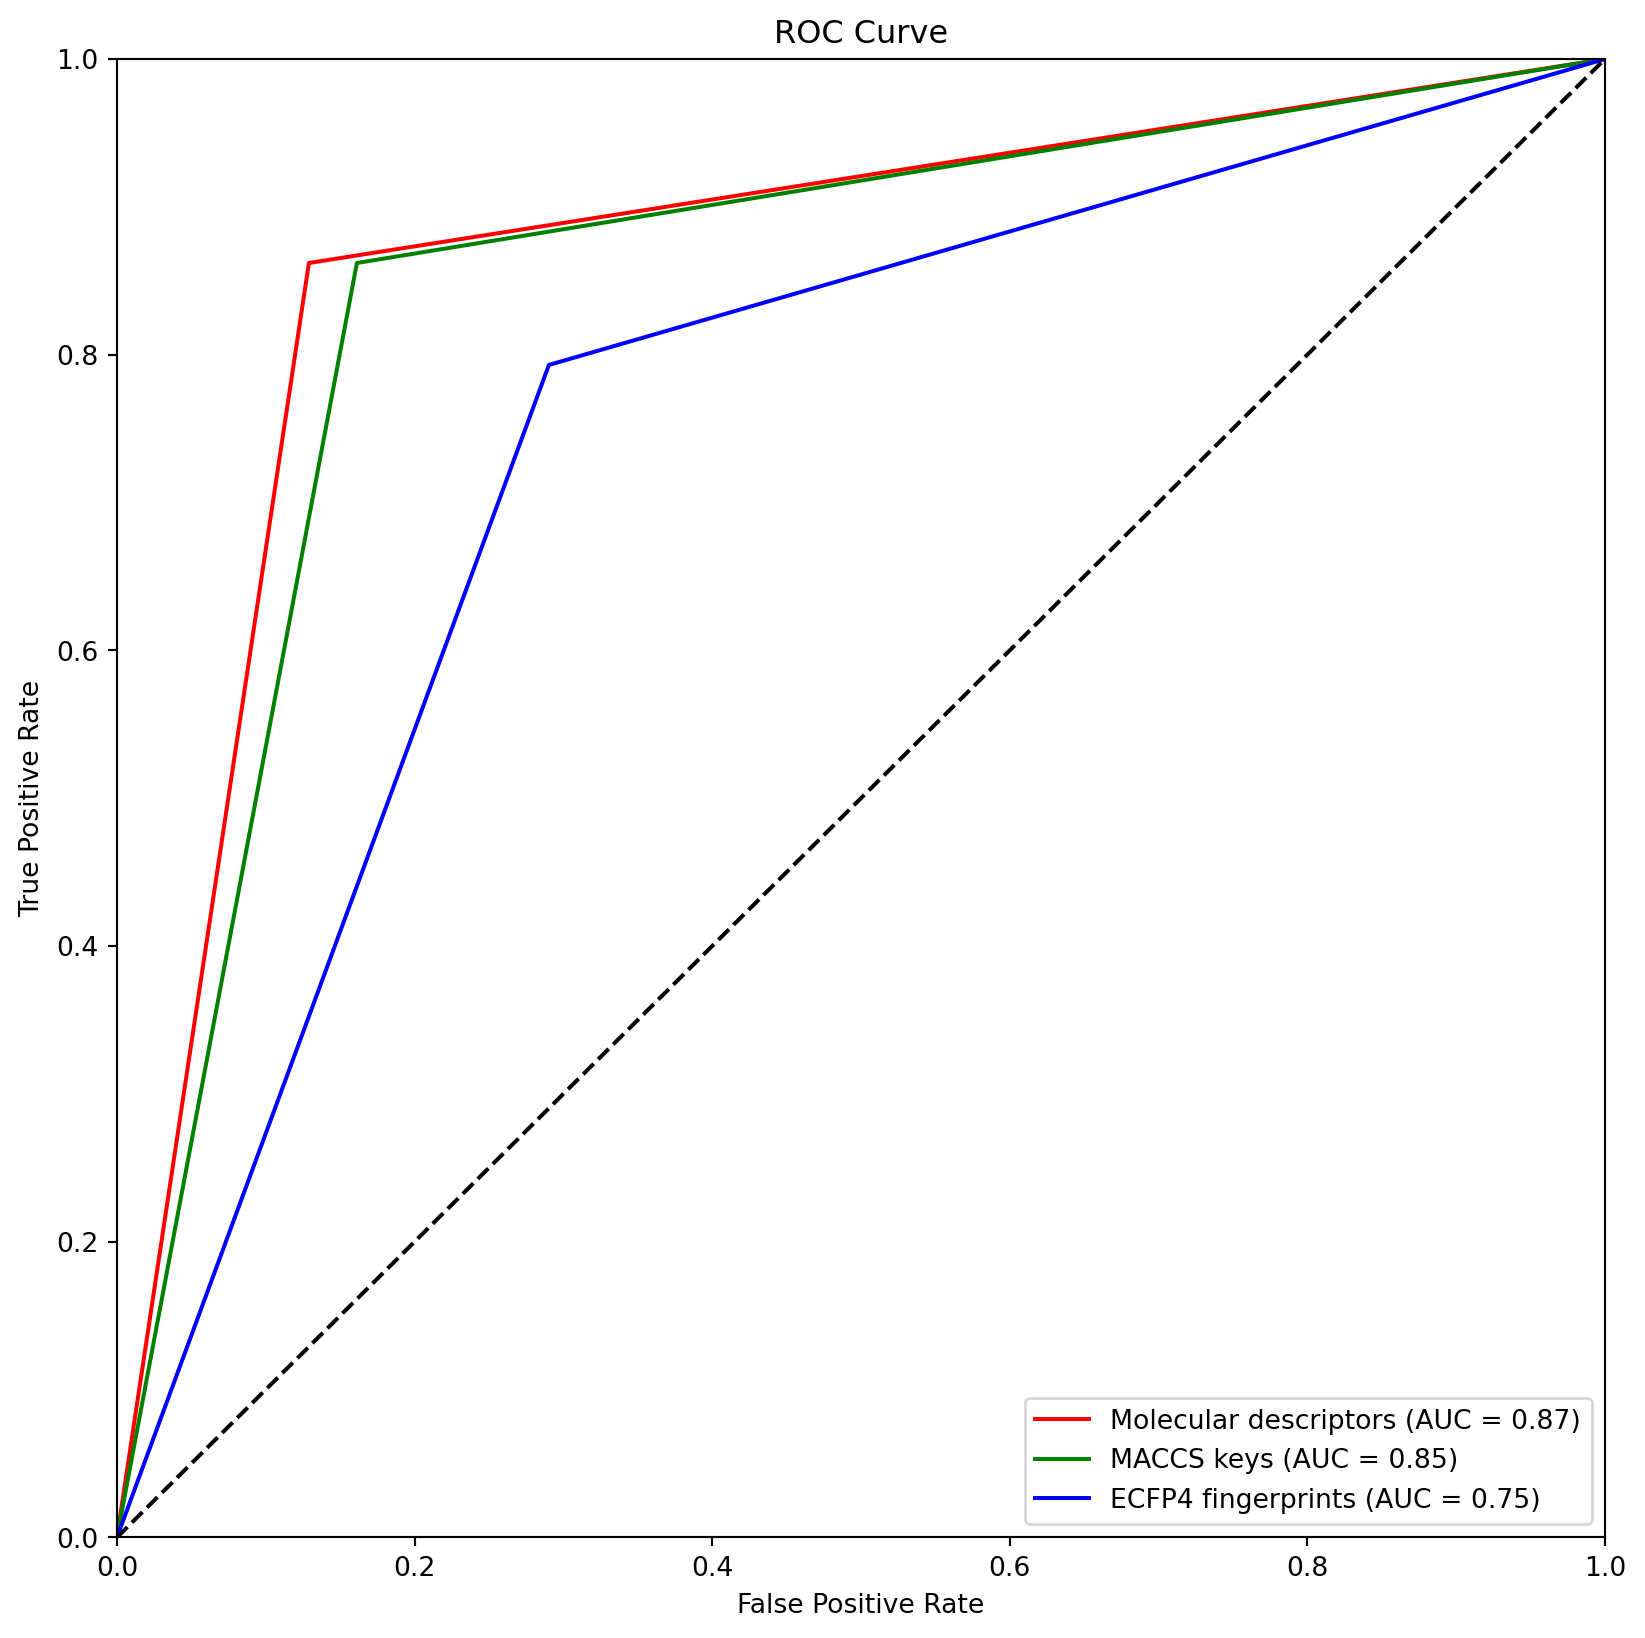

In [19]:
# PLOT ALL THE ROC CURVES IN THE SAME PLOT
plt.figure(figsize=(10, 10))
plt.plot(
    fpr_molecular_descriptors,
    tpr_molecular_descriptors,
    color="red",
    label="Molecular descriptors (AUC = %0.2f)" % auc_molecular_descriptors,
)
plt.plot(
    fpr_maccs_keys,
    tpr_maccs_keys,
    color="green",
    label="MACCS keys (AUC = %0.2f)" % auc_maccs_keys,
)
plt.plot(
    fpr_ecfp4_fingerprints,
    tpr_ecfp4_fingerprints,
    color="blue",
    label="ECFP4 fingerprints (AUC = %0.2f)" % auc_ecfp4_fingerprints,
)
plt.plot([0, 1], [0, 1], color="black", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.savefig(results_path + "knn_roc_curve.png")
plt.show()

In [20]:
# DROP DUPLICATES FROM TABLE_RESULTS.CSV ACCORDING TO MODEL_NAME
table_results = pd.read_csv(results_path + results_file)
table_results = table_results.drop_duplicates(subset=["model_name"])
table_results.to_csv(results_path + results_file, index=False)